<a href="https://colab.research.google.com/github/ValentinaZubareva2906/deep_learning_mipt/blob/main/%D0%BD%D0%B5%D0%B4%D0%B5%D0%BB%D1%8F%203%20%22%D0%9E%D1%82%D1%82%D0%BE%D0%BA%20%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2%22/note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Решение конкурса на kaggle</b></h1>

<h1 style="text-align: center;"><b>"Предсказание оттока пользователей (весна 2021)"</b></h1>

Цель: моделирование оттока клиентов телеком компании. Метрика на тестовых данных должна быть >= 0.84. Взять метрику ROC-AUC.

Задача:
1) сделать предобаботку данных
2) провести исследовательский анализ
3) построить модели.
4) выбрать наилучшую модель, где на тестовых данных будет score  >= 0.84

Описание данных:
- ClientPeriod - период использования компании абониментом
- MonthlySpending - расходы за месяц
- TotalSpent - общие расходы
- Sex - пол абнимента
- IsSeniorCitizen - является ли абонимент пенсионером
- HasChild - есть ли у клиента дети
- HasPhoneService - есть ли телефонный сервис
- HasMultiplePhoneNumbers - подключение телефона к нескольким линиям одновременно
- HasInternetService - тип подключения
- HasOnlineSecurityService -  блокировка опасных сайтов
- HasOnlineBackup - облачное хранилище файлов для резервного копирования данных
- HasDeviceProtection - антивирус
- HasTechSupportAccess - выделенная линия технической поддержки
- HasOnlineTV - наличие онлайн телевилдения
- HasMovieSubscription - есть ли подписка на просмотр фильмов
- HasContractPhone - есть ли контактный телефон
- IsBillingPaperless - является ли выставление счетов безбумажным
- PaymentMethod - тип платежа


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
!pip -q install phik

In [3]:
!pip3 install catboost -q

In [4]:
!pip install tabulate

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,  RobustScaler, OrdinalEncoder ,PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from phik import phik_matrix

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from tabulate import tabulate

In [8]:
RANDOM_STATE = 28072025
TEST_SIZE = 0.25

## Загрузка данных. Предобработка данных.

На данном этапе необходимо:

1) загрузить данные train и test
2) проверить данные на пропуски, дубликаты
3) при обнаружении пропусков необходимо их заменить, при наличии дубликатов, посмотреть стоит ли их удалять.
4) сделать вывод по проделланной предобработке данных.

In [9]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 35.3MB/s]


In [10]:
data_train = pd.read_csv('./train.csv')

In [11]:
display(data_train.head(10))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
5,25,19.80,475.2,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
6,27,90.15,2423.4,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),0
7,1,45.70,45.7,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


In [12]:
print(data_train.columns)

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')


In [13]:
columnname = ['Client_Period', 'Monthly_Spending', 'Total_Spent', 'Sex',
       'Senior_Citizen', 'Partner', 'Child', 'Phone_Service',
       'Multiple_Phone', 'Internet_Service',
       'Online_Service', 'Online_Backup', 'Device_Protection',
       'Tech_Support', 'Online_TV', 'Movie_Subscription',
       'Contract_Phone', 'Billing_Paperless', 'Payment_Method', 'Churn']

data_train = data_train.set_axis(axis=1, labels=columnname)

data_train.columns = data_train.columns.str.lower()

In [14]:
print(data_train.columns)

Index(['client_period', 'monthly_spending', 'total_spent', 'sex',
       'senior_citizen', 'partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method', 'churn'],
      dtype='object')


In [15]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_period       5282 non-null   int64  
 1   monthly_spending    5282 non-null   float64
 2   total_spent         5282 non-null   object 
 3   sex                 5282 non-null   object 
 4   senior_citizen      5282 non-null   int64  
 5   partner             5282 non-null   object 
 6   child               5282 non-null   object 
 7   phone_service       5282 non-null   object 
 8   multiple_phone      5282 non-null   object 
 9   internet_service    5282 non-null   object 
 10  online_service      5282 non-null   object 
 11  online_backup       5282 non-null   object 
 12  device_protection   5282 non-null   object 
 13  tech_support        5282 non-null   object 
 14  online_tv           5282 non-null   object 
 15  movie_subscription  5282 non-null   object 
 16  contra

In [16]:
data_test = pd.read_csv('./test.csv')

In [17]:
display(data_test.head(10))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)
5,20,25.55,507.4,Female,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic)
6,9,90.35,767.9,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,One year,Yes,Electronic check
7,41,113.60,4594.95,Female,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic)
8,72,109.75,8075.35,Female,1,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check
9,23,34.65,768.45,Male,1,No,No,No,No phone service,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic)


In [18]:
print(data_test.columns)

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'],
      dtype='object')


In [19]:
columnname = ['Client_Period', 'Monthly_Spending', 'Total_Spent', 'Sex',
       'Senior_Citizen', 'Partner', 'Child', 'Phone_Service',
       'Multiple_Phone', 'Internet_Service',
       'Online_Service', 'Online_Backup', 'Device_Protection',
       'Tech_Support', 'Online_TV', 'Movie_Subscription',
       'Contract_Phone', 'Billing_Paperless', 'Payment_Method']

data_test = data_test.set_axis(axis=1, labels=columnname)

data_test.columns = data_test.columns.str.lower()

In [20]:
print(data_test.columns)

Index(['client_period', 'monthly_spending', 'total_spent', 'sex',
       'senior_citizen', 'partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method'],
      dtype='object')


In [21]:
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_period       1761 non-null   int64  
 1   monthly_spending    1761 non-null   float64
 2   total_spent         1761 non-null   object 
 3   sex                 1761 non-null   object 
 4   senior_citizen      1761 non-null   int64  
 5   partner             1761 non-null   object 
 6   child               1761 non-null   object 
 7   phone_service       1761 non-null   object 
 8   multiple_phone      1761 non-null   object 
 9   internet_service    1761 non-null   object 
 10  online_service      1761 non-null   object 
 11  online_backup       1761 non-null   object 
 12  device_protection   1761 non-null   object 
 13  tech_support        1761 non-null   object 
 14  online_tv           1761 non-null   object 
 15  movie_subscription  1761 non-null   object 
 16  contra

ВЫВОД: была проведена загрузка данных train и test. Названия колонн в обоих выборках были изменены (приведены к нижнему регистру и сокращены для удобства пользовния).Первичное знакомство показало, что в данных преобладают категоричесские признаки. На этапе предобработки необходимо проверить их на уникальность признаков. Также необходимо посмотреть на дубликаты данных и проверить на пропуски.

In [22]:
print('Количество дубликотов строк в data_train:',data_train.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(data_train.duplicated().sum() / data_train.shape[0]* 100,3))
print('Количество строк:',data_train.shape[0])

Количество дубликотов строк в data_train: 14
Процент дубликатов строк от всего количества строк: 0.265
Количество строк: 5282


In [23]:
print(data_train.isna().sum())

client_period         0
monthly_spending      0
total_spent           0
sex                   0
senior_citizen        0
partner               0
child                 0
phone_service         0
multiple_phone        0
internet_service      0
online_service        0
online_backup         0
device_protection     0
tech_support          0
online_tv             0
movie_subscription    0
contract_phone        0
billing_paperless     0
payment_method        0
churn                 0
dtype: int64


Проверка на дубликаты строк данных data_train показала, что их составляет 14, что является менее 1%, удалять их не будем, поскольку это могут быть данные разных клиентов.
Проверка на пропуски данных data_train показало, что они отусутствуют.

In [24]:
list = ['partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method']

for word in list:
    print(f'уникальные значения столбца {word}: {data_train[word].unique()}\n')

уникальные значения столбца partner: ['Yes' 'No']

уникальные значения столбца child: ['Yes' 'No']

уникальные значения столбца phone_service: ['Yes' 'No']

уникальные значения столбца multiple_phone: ['No' 'Yes' 'No phone service']

уникальные значения столбца internet_service: ['No' 'Fiber optic' 'DSL']

уникальные значения столбца online_service: ['No internet service' 'No' 'Yes']

уникальные значения столбца online_backup: ['No internet service' 'No' 'Yes']

уникальные значения столбца device_protection: ['No internet service' 'No' 'Yes']

уникальные значения столбца tech_support: ['No internet service' 'Yes' 'No']

уникальные значения столбца online_tv: ['No internet service' 'No' 'Yes']

уникальные значения столбца movie_subscription: ['No internet service' 'No' 'Yes']

уникальные значения столбца contract_phone: ['One year' 'Two year' 'Month-to-month']

уникальные значения столбца billing_paperless: ['No' 'Yes']

уникальные значения столбца payment_method: ['Mailed check' 'Credi

In [25]:
list = ['partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method']

for word in list:
  if word == 'payment_method':
    data_train[word] = data_train[word].replace('Bank transfer (automatic)' ,'Bank transfer').replace('Credit card (automatic)' ,'Credit card')
  data_train[word] = data_train[word].replace('No internet service' ,'No internet')
  data_train[word] = data_train[word].replace('No phone service' ,'No phone')
  data_train[word] = data_train[word].str.replace(' ','_').str.lower()
  print(f'уникальные значения столбца {word}: {data_train[word].unique()}\n')

уникальные значения столбца partner: ['yes' 'no']

уникальные значения столбца child: ['yes' 'no']

уникальные значения столбца phone_service: ['yes' 'no']

уникальные значения столбца multiple_phone: ['no' 'yes' 'no_phone']

уникальные значения столбца internet_service: ['no' 'fiber_optic' 'dsl']

уникальные значения столбца online_service: ['no_internet' 'no' 'yes']

уникальные значения столбца online_backup: ['no_internet' 'no' 'yes']

уникальные значения столбца device_protection: ['no_internet' 'no' 'yes']

уникальные значения столбца tech_support: ['no_internet' 'yes' 'no']

уникальные значения столбца online_tv: ['no_internet' 'no' 'yes']

уникальные значения столбца movie_subscription: ['no_internet' 'no' 'yes']

уникальные значения столбца contract_phone: ['one_year' 'two_year' 'month-to-month']

уникальные значения столбца billing_paperless: ['no' 'yes']

уникальные значения столбца payment_method: ['mailed_check' 'credit_card' 'electronic_check' 'bank_transfer']



In [26]:
print('количество строк, где в категориальных признаках стоит "no_internet":',data_train.query('online_service == "no_internet" and online_backup == "no_internet" and device_protection == "no_internet" and tech_support == "no_internet" and online_tv == "no_internet" and movie_subscription == "no_internet"')['online_service'].count())
print('количество строк, где в признаке online_service стоит "no_internet":', data_train.query('online_service == "no_internet"')['online_service'].count())

количество строк, где в категориальных признаках стоит "no_internet": 1141
количество строк, где в признаке online_service стоит "no_internet": 1141


Проверка на уникальные значения показала, что есть пользователи у которых нет подключения к интернету, их нельзя объединить с пользователями, у которых просто нет какой-то опции.

In [27]:
print('Количество клиентов, у которых общих расходов нет:', data_train.query('total_spent == 0')['total_spent'].count())

Количество клиентов, у которых общих расходов нет: 0


In [28]:
print('Количество клиентов, у которых не указаны общие расходы:', data_train.query('total_spent == " "')['total_spent'].count())

Количество клиентов, у которых не указаны общие расходы: 9


In [29]:
display(data_train.query('total_spent == " "').head(10))

,client_period,monthly_spending,total_spent,sex,senior_citizen,partner,child,phone_service,multiple_phone,internet_service,online_service,online_backup,device_protection,tech_support,online_tv,movie_subscription,contract_phone,billing_paperless,payment_method,churn
1048,0,25.75,,Male,0,yes,yes,yes,yes,no,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,two_year,no,mailed_check,0
1707,0,73.35,,Female,0,yes,yes,yes,yes,dsl,no,yes,yes,yes,yes,no,two_year,no,mailed_check,0
2543,0,19.70,,Male,0,yes,yes,yes,no,no,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,one_year,yes,mailed_check,0
3078,0,80.85,,Female,0,yes,yes,yes,no,dsl,yes,yes,yes,no,yes,yes,two_year,no,mailed_check,0
3697,0,20.00,,Female,0,yes,yes,yes,no,no,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,two_year,no,mailed_check,0
4002,0,61.90,,Male,0,no,yes,yes,yes,dsl,yes,yes,no,yes,no,no,two_year,yes,bank_transfer,0
4326,0,25.35,,Male,0,yes,yes,yes,yes,no,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,two_year,no,mailed_check,0
4551,0,52.55,,Female,0,yes,yes,no,no_phone,dsl,yes,no,yes,yes,yes,no,two_year,yes,bank_transfer,0
4598,0,56.05,,Female,0,yes,yes,no,no_phone,dsl,yes,yes,yes,yes,yes,no,two_year,no,credit_card,0


In [30]:
data_train['total_spent'] = data_train['total_spent'].str.replace(' ','0').astype('float')

In [31]:
display(data_train[['client_period', 'monthly_spending', 'total_spent']].describe())

,client_period,monthly_spending,total_spent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161
std,24.550326,30.176464,2269.049195
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


Проверка численных признаков данных data_train показала, что в признаке total_spent имеются пропуски, эти пропуски связаны с тем, что клиент только начал пользоваться данной компанией, период пользования составляет 0, следовательно общих его расходов пока нет, поэтому юыло принято поставить заглушку 0. Также был изменен тип данных на float.
У остальных численных признаков нет пропусков. Более детально рассмотрим их на ииследовательском анализе.

In [32]:
print('Количество дубликотов строк в data_test:',data_test.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк:',round(data_test.duplicated().sum() / data_test.shape[0]* 100,3))
print('Количество строк:',data_test.shape[0])

Количество дубликотов строк в data_test: 3
Процент дубликатов строк от всего количества строк: 0.17
Количество строк: 1761


In [33]:
print(data_test.isna().sum())

client_period         0
monthly_spending      0
total_spent           0
sex                   0
senior_citizen        0
partner               0
child                 0
phone_service         0
multiple_phone        0
internet_service      0
online_service        0
online_backup         0
device_protection     0
tech_support          0
online_tv             0
movie_subscription    0
contract_phone        0
billing_paperless     0
payment_method        0
dtype: int64


In [34]:
list = ['partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method']

for word in list:
    print(f'уникальные значения столбца {word}: {data_test[word].unique()}\n')

уникальные значения столбца partner: ['Yes' 'No']

уникальные значения столбца child: ['No' 'Yes']

уникальные значения столбца phone_service: ['Yes' 'No']

уникальные значения столбца multiple_phone: ['Yes' 'No' 'No phone service']

уникальные значения столбца internet_service: ['DSL' 'Fiber optic' 'No']

уникальные значения столбца online_service: ['Yes' 'No' 'No internet service']

уникальные значения столбца online_backup: ['No' 'Yes' 'No internet service']

уникальные значения столбца device_protection: ['No' 'Yes' 'No internet service']

уникальные значения столбца tech_support: ['No' 'Yes' 'No internet service']

уникальные значения столбца online_tv: ['No' 'Yes' 'No internet service']

уникальные значения столбца movie_subscription: ['No' 'Yes' 'No internet service']

уникальные значения столбца contract_phone: ['One year' 'Month-to-month' 'Two year']

уникальные значения столбца billing_paperless: ['No' 'Yes']

уникальные значения столбца payment_method: ['Credit card (automat

In [35]:
list = ['partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method']

for word in list:
  if word == 'payment_method':
    data_test[word] = data_test[word].replace('Bank transfer (automatic)' ,'Bank transfer').replace('Credit card (automatic)' ,'Credit card')
  data_test[word] = data_test[word].replace('No internet service' ,'No internet')
  data_test[word] = data_test[word].replace('No phone service' ,'No phone')
  data_test[word] = data_test[word].str.replace(' ','_').str.lower()
  print(f'уникальные значения столбца {word}: {data_test[word].unique()}\n')

уникальные значения столбца partner: ['yes' 'no']

уникальные значения столбца child: ['no' 'yes']

уникальные значения столбца phone_service: ['yes' 'no']

уникальные значения столбца multiple_phone: ['yes' 'no' 'no_phone']

уникальные значения столбца internet_service: ['dsl' 'fiber_optic' 'no']

уникальные значения столбца online_service: ['yes' 'no' 'no_internet']

уникальные значения столбца online_backup: ['no' 'yes' 'no_internet']

уникальные значения столбца device_protection: ['no' 'yes' 'no_internet']

уникальные значения столбца tech_support: ['no' 'yes' 'no_internet']

уникальные значения столбца online_tv: ['no' 'yes' 'no_internet']

уникальные значения столбца movie_subscription: ['no' 'yes' 'no_internet']

уникальные значения столбца contract_phone: ['one_year' 'month-to-month' 'two_year']

уникальные значения столбца billing_paperless: ['no' 'yes']

уникальные значения столбца payment_method: ['credit_card' 'electronic_check' 'bank_transfer' 'mailed_check']



In [36]:
print('количество строк, где в категориальных признаках стоит "no_internet":',data_test.query('online_service == "no_internet" and online_backup == "no_internet" and device_protection == "no_internet" and tech_support == "no_internet" and online_tv == "no_internet" and movie_subscription == "no_internet"')['online_service'].count())
print('количество строк, где в признаке online_service стоит "no_internet":', data_test.query('online_service == "no_internet"')['online_service'].count())

количество строк, где в категориальных признаках стоит "no_internet": 385
количество строк, где в признаке online_service стоит "no_internet": 385


In [37]:
print('Количество клиентов, у которых общих расходов нет:', data_test.query('total_spent == 0')['total_spent'].count())

Количество клиентов, у которых общих расходов нет: 0


In [38]:
print('Количество клиентов, у которых не указаны общие расходы:', data_test.query('total_spent == " "')['total_spent'].count())

Количество клиентов, у которых не указаны общие расходы: 2


In [39]:
data_test['total_spent'] = data_test['total_spent'].str.replace(' ','0').astype('float')

In [40]:
display(data_test[['client_period', 'monthly_spending', 'total_spent']].describe())

,client_period,monthly_spending,total_spent
count,1761.000000,1761.000000,1761.000000
mean,32.293583,64.272601,2256.483135
std,24.593736,29.832517,2260.501794
min,0.000000,18.550000,0.000000
25%,9.000000,35.650000,405.600000
50%,29.000000,70.050000,1356.300000
75%,56.000000,89.400000,3759.050000
max,72.000000,117.350000,8496.700000


С данными data_test была проведена аналогичная предобработка данных. Было выявлено наличие дубликатов, их составляет менее 1%, было принято решение их не удалять. Было выявлены также пропуски в значениях total_spent, была поставлена заглушка 0.

ВЫВОД: была проведена предобработка данных. Было сделано:
- проведена проверка на наличие явных дубликатов, их составило менее 1% в обоих датасетах, поскольку данных мало, было принято решение из не удалять.
- в категориальных признаках была преведена проверка на уникальность значений, было выявлено значение "no_internet". Пользователи у которых нет подключения к интернету, их нельзя объединить с пользователями, у которых просто нет какой-то опции.
- в количественном признаке total_spent были выявлены пропуски, на них была поставлена заглушка 0, поскольку это те клиенты, которые только недавно ими стали.

## Анализ данных

На данном этапе необходимо:
1) провести исследовательский анализ данных
2) провести корреляционный анализ данных и выяснить есть ли признаки с мультиколллениарностью.
3) построить распределение целевой переменной и выяснить, являются ли классы несбалансированными


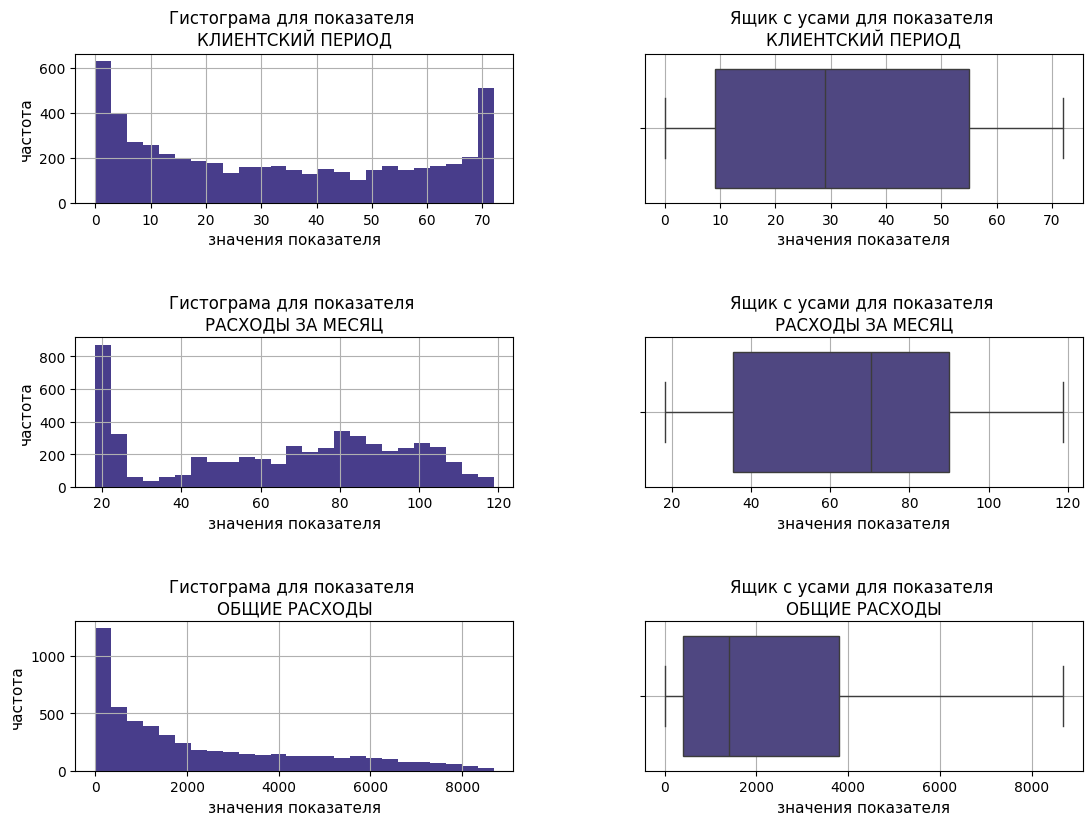

In [41]:
position = 0
plt.figure(figsize=[13,13])
plt.subplots_adjust(wspace=0.3, hspace=0.9)

list = ['client_period', 'monthly_spending', 'total_spent']
list_1 = ['клиентский период', 'расходы за месяц', 'общие расходы']

for name in list:
    position += 1

    df1 = data_train[name]
    name_1 = list_1[list.index(name)]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = '#483D8B', bins = 25)
    plt.title(f'Гистограма для показателя \n{name_1.upper()}', fontsize=12)
    plt.xlabel('значения показателя', fontsize=11)
    plt.ylabel('частота', fontsize=11)
    plt.grid(True)

    position += 1
    df2 = data_train[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = '#483D8B')
    plt.title(f'Ящик с усами для показателя \n{name_1.upper()}', fontsize=12)
    plt.xlabel('значения показателя',fontsize=11)
    plt.grid(True);

In [42]:
print(f'Характеристики количественных показателей данных')
display(data_train[['client_period', 'monthly_spending', 'total_spent']].describe())

Характеристики количественных показателей данных


,client_period,monthly_spending,total_spent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161
std,24.550326,30.176464,2269.049195
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


In [43]:
data = data_train.reset_index()

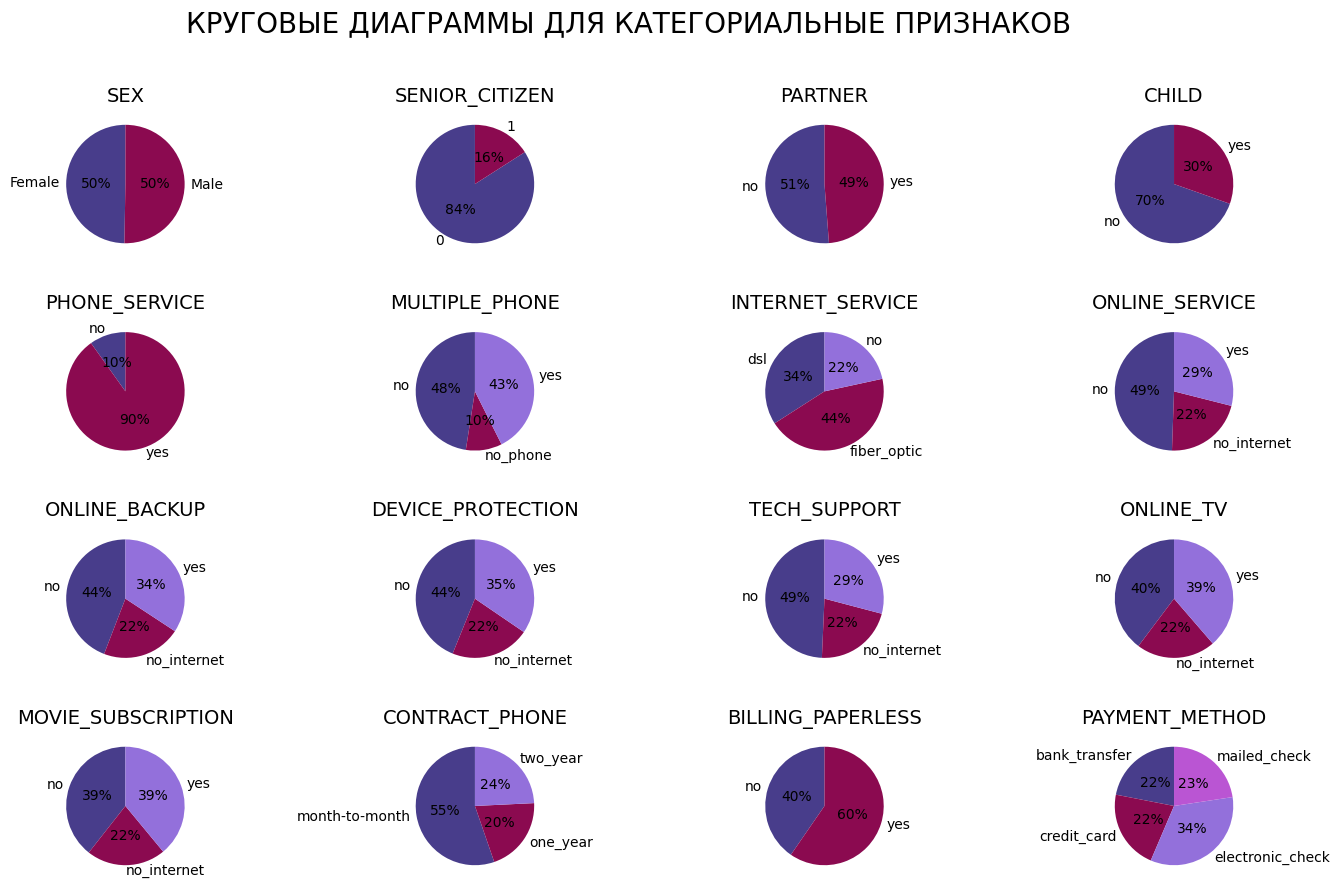

In [44]:
fig = plt.figure(figsize=(17,10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.suptitle("КРУГОВЫЕ ДИАГРАММЫ ДЛЯ КАТЕГОРИАЛЬНЫЕ ПРИЗНАКОВ",fontsize=20)
i= 0
r,c = 0 ,0   # rows(r) and columns(c)

list = ['sex','senior_citizen', 'partner', 'child', 'phone_service', 'multiple_phone',
       'internet_service', 'online_service', 'online_backup',
       'device_protection', 'tech_support', 'online_tv', 'movie_subscription',
       'contract_phone', 'billing_paperless', 'payment_method']

for i in range(16):
    if i < 4:
        name = list[i]
        name_1 = list[list.index(name)]
        ax1 = plt.subplot2grid((4,4), (r, c))
        df1 = data.pivot_table(index = name, values = 'index', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['index'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90,
                pctdistance=0.5)
        plt.title(f'{name_1.upper()}', fontsize=14);
        c +=1
        i+=1
    elif (i > 3) and (i < 8):
        name = list[i]
        name_1 = list[list.index(name)]
        if i == 4:
          c = 0
        r = 1
        ax1 = plt.subplot2grid((4,4), (r, c))
        df1 = data.pivot_table(index = name, values = 'index', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['index'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90,
                pctdistance=0.5)
        plt.title(f'{name_1.upper()}', fontsize=14);
        c +=1
        i += i

    elif (i > 7) and (i < 12):
        name = list[i]
        name_1 = list[list.index(name)]
        if i == 8:
          c = 0
        r = 2
        ax1 = plt.subplot2grid((4,4), (r, c))
        df1 = data.pivot_table(index = name, values = 'index', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['index'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90,
                pctdistance=0.5)
        plt.title(f'{name_1.upper()}', fontsize=14);
        c +=1
        i += i

    else:
        name = list[i]
        name_1 = list[list.index(name)]
        if i == 12:
          c = 0
        r = 3
        ax1 = plt.subplot2grid((4,4), (r, c))
        df1 = data.pivot_table(index = name, values = 'index', aggfunc = 'count')
        labels = df1.reset_index()[name]
        plt.pie(df1['index'],labels = labels,autopct='%.0f%%',colors=['#483D8B','#8B0A50','mediumpurple', 'mediumorchid'],
                startangle=90,
                pctdistance=0.5)
        plt.title(f'{name_1.upper()}', fontsize=14);
        c += 1
        i += 1



plt.show()

ВЫВОД: исследовательский анализ даннных показал, что:
- абоненты предпочитают оплату ежемесячную(55%), меньше всего берут оплату за два года.
- предпочитают оплату электронным расчётным листом(60%), хотя разрыв небольшой.
- оплату предпочитают проводить через электронные платежи (34%), остальные типы платежа распределились, практически, равномерно.
- средний расход на месяц составляет 64.8, максимальный - 118.75, минимальный - 18.25. Пик значений в районе 20 характерен для клиентов, которые оформляют договор и сразу его закрывают.
средний общий расход составляет 2287.5. МИнимальный расход составляет 0 - это у тех клиентов, которые заключили договор в последний месяц данных, которые выгрузили.
- клиенты, у которых за месяц меньше 21 (в районе пика), не являются клинтами, которые только заключили контракт в последний месяц данных, которые выгрузили1. Такие низкие данные за расчёты на месяц не являются анамалиями. Возможно эти клиенты не пользуются другими услугами оператора или пользуются очень малыми опциями.
- клиенты, у которых очень большие общие расходы, являются клиентами уже длительное время и возможно также пользуются дополнительными функциями от оператора. Низкие общие расходы, говорит о том, что пользователь только начал пользоваться данным оператором.
- мужчины и жунщины в равной степени выбирают данный оператор связи.
- в основном данный оператор выбирают молодые люди, пенсионеры составляют 16%.
данный оператор связи выбирают, практически, поровну как люди в браке, так и холостые. Отрыв в пользу холостых составляет 3%.
- данный оператор выбирают люди, которые не имеют детей, их 70% от всех пользоватлей.
- пользователи предпочитают подключение fiber_optic(44%)
- клиенты предпочитают не пользоваться блокировкой опасных сайтов (63%)
- пользователи предпочитают не пользоваться хранилищем данных (44%) и также не пользоваться антивирусом (44%)
- клиенты чаще всего не пользуются выделенной линией поддержки (48%)
- пользователи, практически, в равной степени пользуются стриминговым телевидением(44% - да).

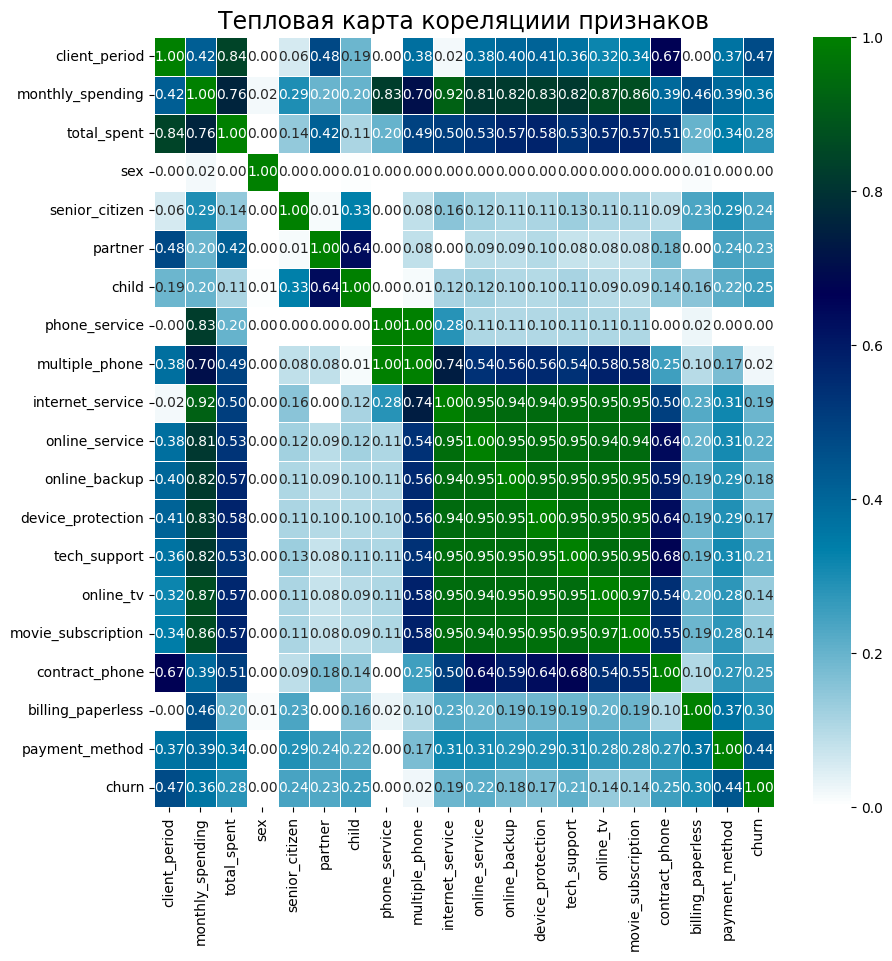

In [45]:
plt.figure(figsize=(10, 10));
sns.heatmap(
    data_train.phik_matrix(interval_cols=['client_period', 'monthly_spending', 'total_spent'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap = "ocean_r"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

In [46]:
#data_train = data_train.drop(['sex', 'phone_service','tech_support', 'movie_subscription','internet_service'], axis=1)
data_train = data_train.drop(['sex'], axis=1)

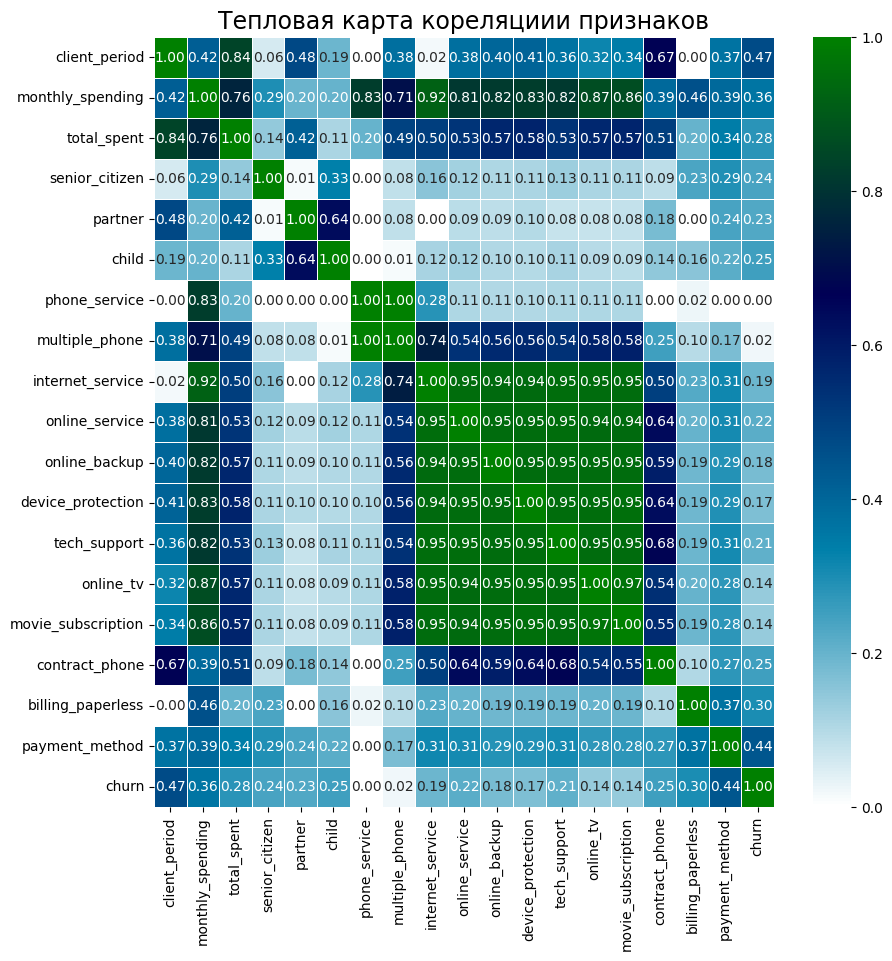

In [47]:
plt.figure(figsize=(10, 10));
sns.heatmap(
    data_train.phik_matrix(interval_cols=['client_period', 'monthly_spending', 'total_spent'])
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap = "ocean_r"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

ВЫВОД: корреляционный анализ показал, что в данных присутсвует мультиколлениарность. Было принято решение удалить признак 'sex', поскольку он не оказывает влияние ни на какие признаки.

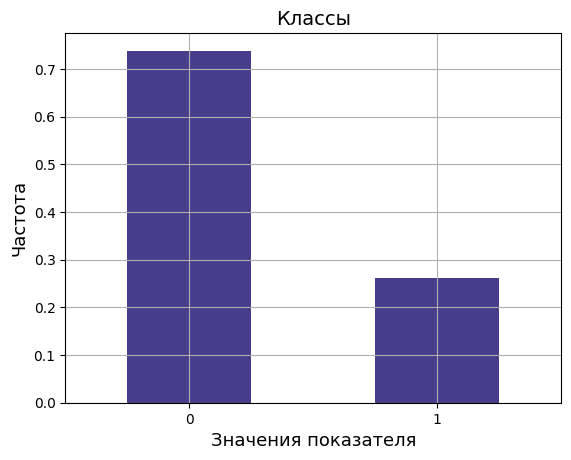

In [48]:
data_train['churn'].value_counts(normalize=True).plot(kind='bar', color = '#483D8B')
plt.title('Классы',fontsize=14)
plt.xlabel('Значения показателя', fontsize=13)
plt.ylabel('Частота', fontsize=13)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

ВЫВОД: датасет разбит в пропорции, приблизительно 3:1. Необходимо будет применять стратификацию по целевой переменной(чтобы сохранить баланс).

## ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ

На данном этапе необходимо разделить выборку тренировочных данных на обучающую и валидационую. Проверить разделение.
Далее необходимо обучить две модели: логистическая регрессия и бустинг. Для каждой архитектуры подобрать гиперпараметры и выбрать лучшую модель на метрике AUC-ROC >= 0.84, если метрика будет приближаться к 100% - идет переобучение, тогда необходимо изменить подбор параметров, проконтролировать утечку. Также необходимо при обучении учитывать баланс классов.


In [49]:
X = data_train.drop('churn', axis=1)
y = data_train['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [50]:
print(
    f'Разделение выборки в следующих пропорциях:\n'
    f'{(len(X_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(X_val)/len(data)):.0%} — тестовая;'
)

Разделение выборки в следующих пропорциях:
75% — тренировочная;
25% — тестовая;


In [51]:
print(
    f'Размер матриц:\n'
    f'{X_train.shape[0], y_train.shape[0]} — тренировочная;\n'
    f'{X_val.shape[0], y_val.shape[0]} — тестовая;\n'
)

Размер матриц:
(3961, 3961) — тренировочная;
(1321, 1321) — тестовая;



In [52]:
num_columns = ['client_period', 'monthly_spending', 'total_spent']
ohe_columns = ['senior_citizen',
       'partner', 'child', 'multiple_phone', 'online_service', 'online_backup',
       'device_protection', 'online_tv', 'contract_phone', 'billing_paperless',
       'payment_method','phone_service','tech_support', 'movie_subscription','internet_service']
ord_columns = ['senior_citizen',
       'partner', 'child', 'multiple_phone', 'online_service', 'online_backup',
       'device_protection', 'online_tv', 'contract_phone', 'billing_paperless',
       'payment_method','phone_service','tech_support', 'movie_subscription','internet_service']

In [53]:
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error'))])

In [54]:
ord_pipe = Pipeline([('ord',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan))])

In [55]:
num_pipe = Pipeline([('robustscaler', RobustScaler()),
                ('powertransform', PowerTransformer())])

In [56]:
data_preprocessor_lir = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num',  num_pipe, num_columns)],
    remainder='passthrough'
)

In [57]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)],
    remainder='passthrough'
)

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [58]:
pipe_lir = Pipeline(
    [
        ('preprocessor', data_preprocessor_lir),
        ('lir', LogisticRegression(class_weight = 'balanced',solver='liblinear', penalty='l1', random_state=RANDOM_STATE))

    ]
)


In [59]:
parameters_lir = {
    'lir__C': [1, 10, 50, 100, 150],
    'lir__max_iter': [10, 50, 100],
}

In [60]:
lir_grid = GridSearchCV(pipe_lir, parameters_lir, cv=3, scoring='roc_auc', verbose=False, n_jobs=-1, error_score = 'raise')

In [61]:
lir_grid.fit(X_train, y_train)

lir_fit_score = lir_grid.best_score_
print('Лучшая модель и её параметры:', lir_grid.best_estimator_)
print(f'Лучший показатель ROC-AUC: {lir_fit_score:.3f}')

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['senior_citizen', 'partner',
                                                   'child', 'multiple_phone',
                                                   'online_service',
                                                   'online_backup',
                                                   'device_protection',
                                                   'online_tv',
                                                   'contract_phone',
                                                   'billing_paperless',
                                                   'payment_method',
      

ГРАДИЕНТНЫЙ БУСТИНГ

In [62]:
pipe_cat = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('cat', CatBoostClassifier(random_state = RANDOM_STATE,logging_level='Silent', loss_function='Logloss'))
    ]
)

In [63]:
param_cat = {
        'cat__depth': range(4, 10),
        'cat__learning_rate':np.arange(0.1,1,0.2)
}

In [64]:
cat_grid = GridSearchCV(pipe_cat, param_cat, scoring='roc_auc', cv=3, n_jobs=-1, error_score = 'raise')

In [65]:
cat_grid.fit(X_train, y_train)
cat_fit_score = cat_grid.best_score_
print('Лyчшая модель и её параметры:', cat_grid.best_estimator_)
print(f'Лучший показатель ROC-AUC: {cat_fit_score:.3f}')

Лyчшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['senior_citizen', 'partner',
                                                   'child', 'multiple_phone',
                                                   'online_service',
                                                   'online_backup',
                                                   'device_protection',
                                                   'online_tv',
                                                   'contract_phone',
                       

In [66]:
y_pred_lir = lir_grid.best_estimator_.predict_proba(X_val)[:, 1]
roc_auc_lir = roc_auc_score(y_val, y_pred_lir)

print('AUC-ROC на тестовом наборе данных:', round(roc_auc_lir, 3))


AUC-ROC на тестовом наборе данных: 0.841


In [67]:
y_pred_cat = cat_grid.best_estimator_.predict_proba(X_val)[:, 1]
roc_auc_cat = roc_auc_score(y_val, y_pred_cat)

print('AUC-ROC на тестовом наборе данных:', round(roc_auc_cat, 3))

AUC-ROC на тестовом наборе данных: 0.81


In [68]:
catboost_model = cat_grid.best_estimator_.named_steps['cat']
logistic_model = lir_grid.best_estimator_.named_steps['lir']

In [69]:
table = [
    ['LogisticRegression',logistic_model.get_params(), round(lir_fit_score,3), round(roc_auc_lir, 3)],
    ['CatBoostClassifier',catboost_model.get_params(), round(cat_fit_score,3), round(roc_auc_cat, 3)],
]
columns = ['model', 'parameters', 'roc_auc_train', 'roc_auc_val']

print(tabulate(table,headers=columns,maxcolwidths = 20*4,tablefmt='fancy_grid', colalign=("center","center", "center", "center")))

╒════════════════════╤════════════════════════════════════════════════════════════════════════════╤═════════════════╤═══════════════╕
│       model        │                                 parameters                                 │  roc_auc_train  │  roc_auc_val  │
╞════════════════════╪════════════════════════════════════════════════════════════════════════════╪═════════════════╪═══════════════╡
│ LogisticRegression │ {'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, │      0.844      │     0.841     │
│                    │  'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10, 'multi_class':  │                 │               │
│                    │  'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 28072025,  │                 │               │
│                    │  'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}  │                 │               │
├────────────────────┼────────────────────────────────────────

ВЫВОД: были построены модели логистической регрессии и градиентного бустинга. Лучше на тренировочной выборке показала Логистическая регрессия (roc_auc = 0.844). Для повышения точности модели можно провести анализ важности признаков.
На тестовой выборке roc-auc - 0.846.

# Предсказания

In [70]:
best_model = liwwr_grid.best_estimator_# какая-то предыдущая модель

NameError: name 'liwwr_grid' is not defined

In [ ]:
X_test = data_test
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv')

Лучшее решение отправьте в Stepik.